<a href="https://colab.research.google.com/github/tGhattas/DL/blob/master/MNIST_AE_latent_space_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title This notebook demonstrate GAN based implementation to learn the latent space of an Auto Encoder
#@markdown The AE is CNN trained on MNIST data set.

#@markdown We transfare the weights of the AE-Decoder to a MLP classifier.

#@markdown We then build on that a Discriminator to help train a Generator that gets an input either a i.i.d Gaussian noise and output a digit latent vector in the AE latent space or gets along with the random noise a digit and outputs a latent vector corresponding to an image of that digit.

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np
import os

from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#@markdown Try to use GPU...
my_devices = tf.config.experimental.list_physical_devices(device_type='GPU') 
tf.config.experimental.set_visible_devices(devices=my_devices, device_type='GPU')
print(f'Colab is using GPU: {my_devices}' if len(my_devices) else 'Colab is using CPU only.')
best_available_device = my_devices[0] if len(my_devices) else None 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Colab is using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tue Jan 19 21:59:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    24W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
 

In [4]:
latent_dim = 64
noise_sigma = 0.35
sml_train_size = 50 #TODO

# load train and test images, and pad & reshape them to (-1,32,32,1)
(x_train, y_train_numerical), (x_test, y_test_numerical) = mnist.load_data()
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)).astype('float32') / 255.0
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)).astype('float32') / 255.0
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2), (0, 0)))
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2), (0, 0)))
print(x_train.shape)
print(x_test.shape)

(60000, 32, 32, 1)
(10000, 32, 32, 1)


In [5]:
y_train = keras.utils.to_categorical(y_train_numerical, num_classes=10, dtype='float32')
y_test = keras.utils.to_categorical(y_test_numerical, num_classes=10, dtype='float32')

encoder = Sequential()
encoder.add(layers.Conv2D(16, (4, 4), strides=(2, 2), activation='relu', padding='same', input_shape=(32, 32, 1)))
encoder.add(layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))
encoder.add(layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))
encoder.add(layers.Conv2D(96, (3, 3), strides=(2, 2), activation='relu', padding='same'))
encoder.add(layers.Reshape((2 * 2 * 96,)))
encoder.add(layers.Dense(latent_dim))

decoder = Sequential()
decoder.add(layers.Dense(2 * 2 * 96, activation='relu', input_shape=(latent_dim,)))
decoder.add(layers.Reshape((2, 2, 96)))
decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))
decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))
decoder.add(layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), activation='relu', padding='same'))
decoder.add(layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), activation='sigmoid', padding='same'))

autoencoder = keras.Model(encoder.inputs, decoder(encoder.outputs))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
#@title Auto Encoder Trainer
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/DL5/AE_model_save/cp.ckpt"
train_AE = False #@param {type:"boolean"}

if train_AE:
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True)
    autoencoder.fit(x_train + noise_sigma * np.random.randn(*x_train.shape), x_train,
                    verbose=0,
                    epochs=15,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[cp_callback, TqdmCallback(verbose=1)])
else:
    autoencoder.load_weights(checkpoint_path)

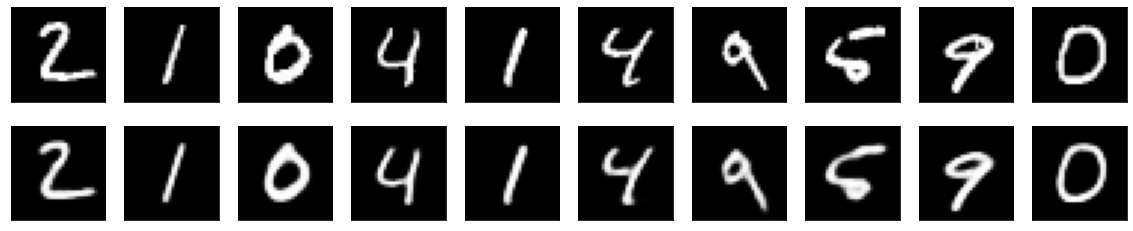

In [7]:
def sample_display(n, xs, ys):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n + 1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(xs[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(ys[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

decoded_imgs = autoencoder.predict(x_test)
latent_codes = encoder.predict(x_test)
decoded_imgs = decoder.predict(latent_codes)

sample_display(10, x_test, decoded_imgs)

In [8]:
def plot(models, attrs=None):

    for k in attrs or ['val_loss', 'val_accuracy']:
        plt.figure()
        for model in models:
            plt.plot(model.history.history[k], label=model.name)
        plt.title(k.title().replace('_', ' '))
        plt.ylabel('value')
        plt.xlabel('No. epoch')
        plt.legend(loc="upper left")
        plt.show()


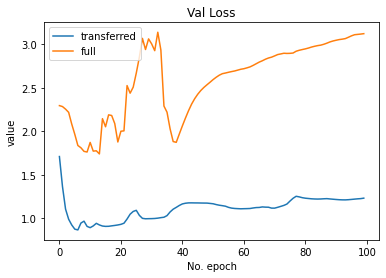

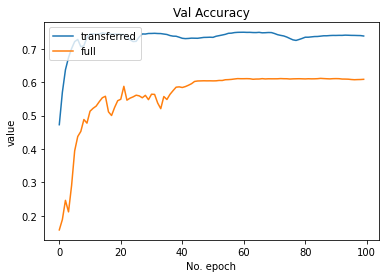

In [9]:
#@title Transfer Learning
classifier = Sequential(name='transferred')
classifier.add(layers.Dense(1024, activation='relu', input_shape=(latent_dim,)))
classifier.add(layers.Dropout(0.2))
classifier.add(layers.Dense(128, activation='relu'))
classifier.add(layers.Dropout(0.2))
classifier.add(layers.Dense(10, activation='softmax'))

train_codes = encoder.predict(x_train[:sml_train_size])
test_codes = encoder.predict(x_test)

classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

classifier.fit(train_codes, y_train[:sml_train_size],
              verbose=0,
              epochs=100,
              batch_size=16,
              shuffle=True,
              validation_data=(test_codes, y_test), callbacks=[TqdmCallback(verbose=1)])

full_cls_enc = keras.models.clone_model(encoder)
full_cls_cls = keras.models.clone_model(classifier)
full_cls = keras.Model(full_cls_enc.inputs, full_cls_cls(full_cls_enc.outputs), name='full')

full_cls.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

full_cls.fit(x_train[:sml_train_size], y_train[:sml_train_size],
            epochs=100,
            verbose=0,
            batch_size=16,
            shuffle=True,
            validation_data=(x_test, y_test),
            callbacks=[TqdmCallback(verbose=1)])
#@markdown we plot the comparison between a full MLP without pretrained weights against the transfered based classifier on 50 training examples and 100 epochs.
plot([classifier, full_cls])


In [10]:
#@title Generator & Discriminator Definition

# generator
generator_input_dim = 32
generator = Sequential(name='generator')
generator.add(layers.Dense(1024, activation='relu',
              input_shape=(None, generator_input_dim,)))
generator.add(layers.Dense(128, activation='relu'))
generator.add(layers.Dense(latent_dim))

# discriminator for the validity of a latent vector
consolidator = Sequential(name='consolidator')
consolidator.add(layers.Dense(10, activation='relu',
                              input_shape=classifier.output_shape))
consolidator.add(layers.Dense(512, activation='relu'))
consolidator.add(layers.Dense(1, activation='sigmoid'))
discriminator_1 = tf.keras.Model(classifier.inputs,
                                consolidator(classifier.outputs),
                                name="discriminator_1")

# discriminator with classification of the different digits corresponding latent vectors
discriminator_input = layers.Input(shape=(10 + latent_dim,))
comparison_layer = layers.Dense(512, activation='relu')(discriminator_input)
comparison_layer = layers.Dense(64, activation='relu')(comparison_layer)
binary_score = layers.Dense(1, activation='sigmoid')(comparison_layer)
discriminator_2 = tf.keras.Model(inputs=discriminator_input,
                                outputs=binary_score,
                                name="discriminator_2")


In [11]:
#@title GAN Implementaion

class GAN(keras.Model):
    def __init__(self, discriminator, generator, GAN_latent_dim,
                 with_user_input=False, name='GAN', train_disc=True):
        super(GAN, self).__init__(name=name)
        self.discriminator = discriminator
        self.generator = generator
        self.GAN_latent_dim = GAN_latent_dim
        self.with_user_input = with_user_input
        self.train_disc = train_disc

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn


    def train_step(self, real_latent_vector):
        """ 
        if with_user_input = True, the real_latent_vector should be a tuple
        (user_input, real_latent_vector) otherwise, its the real_latent_vector
        """

        if self.with_user_input:
          user_input = real_latent_vector[:, :1]
          real_latent_vector = real_latent_vector[:, 1:]

        # Sample random points in the latent space
        batch_size = tf.shape(real_latent_vector)[0]
        random_generator_input = tf.random.normal(shape=(batch_size,
                                                        self.GAN_latent_dim - int(self.with_user_input)))
        
        if self.with_user_input:

            random_user_input_digit = tf.dtypes.cast(tf.random.uniform((batch_size,1), 0, 10, dtype=tf.int32), tf.float32)
            random_generator_input = tf.concat([random_user_input_digit,
                                              random_generator_input], axis=1)

            one_hots = tf.one_hot(tf.dtypes.cast(user_input, tf.int32), depth=10)
            one_hots = tf.convert_to_tensor(one_hots)
            real_latent_labels = tf.dtypes.cast(one_hots[:, 0, :], tf.float32)

            one_hots = tf.one_hot(tf.dtypes.cast(random_user_input_digit, tf.int32), depth=10)
            one_hots = tf.convert_to_tensor(one_hots)
            fake_latent_labels = tf.dtypes.cast(one_hots[:, 0, :], tf.float32)

            class_labels = tf.concat(
              [fake_latent_labels, real_latent_labels], axis=0
            )

        # Decode them to fake latent codes
        fake_latent_vectors = self.generator(random_generator_input)

        # Combine them with real AE latent codes
        combined_vecs = tf.concat([fake_latent_vectors, real_latent_vector], axis=0)
        if self.with_user_input:
            # concatenate one-hot labels to the input of the discriminator
            combined_vecs = tf.concat([class_labels, combined_vecs], axis=1)

        # Assemble labels discriminating real from fake latent code
        binary_labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to enhance training
        binary_labels += 0.05 * tf.random.uniform(tf.shape(binary_labels))

        # Train the discriminator
        if self.train_disc:
            with tf.GradientTape() as tape:
                predictions = self.discriminator(combined_vecs)
                d_loss = self.loss_fn(binary_labels, predictions)

            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
        else:
            predictions = self.discriminator(combined_vecs)
            d_loss = self.loss_fn(binary_labels, predictions)
        # Sample random points in the latent space
        random_generator_input = tf.random.normal(shape=(batch_size,
                                                        self.GAN_latent_dim - int(self.with_user_input)))
        # label all as real
        misleading_labels = tf.zeros((batch_size, 1))
        if self.with_user_input:
            random_user_input_digit = tf.dtypes.cast(tf.random.uniform((batch_size,1), 0, 10, dtype=tf.int32), tf.float32)
            random_generator_input = tf.concat([random_user_input_digit,
                                              random_generator_input], axis=1)
            
            one_hots = tf.one_hot(tf.dtypes.cast(random_user_input_digit, tf.int32), depth=10)
            one_hots = tf.convert_to_tensor(one_hots)
            fake_latent_labels = tf.dtypes.cast(one_hots[:, 0, :], tf.float32)

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            discriminator_input = self.generator(random_generator_input)
            if self.with_user_input:
                discriminator_input =  tf.concat([fake_latent_labels,
                                                  discriminator_input], axis=1)
            predictions = self.discriminator(discriminator_input) 
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [12]:
#@title Visualize Generater Some Outputs
def plot_generator_ouputs(gan_):
    samples_num = 20 #@param {type:"integer"}
    # Generate some samples using the trained generator and decod as images with the decoder
    decoded_imgs = []
    for i in range(samples_num):
        rand_vec = tf.random.normal(shape=(1, generator_input_dim-int(with_user_input)))
        if gan_.with_user_input:
          rand_vec = tf.concat([tf.constant(i%10, dtype=tf.float32, shape=(1,1)),
                                rand_vec], axis=1)
        gen_prediction = gan_.generator.predict(rand_vec)
        decoded_imgs.append(decoder.predict(gen_prediction))
    f, ax = plt.subplots(1, samples_num, figsize=(2*samples_num,10))
    for i, dim in enumerate(decoded_imgs):
      ax[i].imshow(dim.reshape(32, 32))
    plt.gray()
    plt.axis('off')
    plt.show()


In [13]:
#@markdown A custom made callback to help visualize the generator performance along the epochs
class PlotGenOutputsCallback(keras.callbacks.Callback):
    def __init__(self, gen, step=1):
        self.step = step
        self.gen = gen
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.step == 0:
            print(f"End epoch {epoch} of training, plotting Generator results:")
            plot_generator_ouputs(self.gen)

End epoch 0 of training, plotting Generator results:


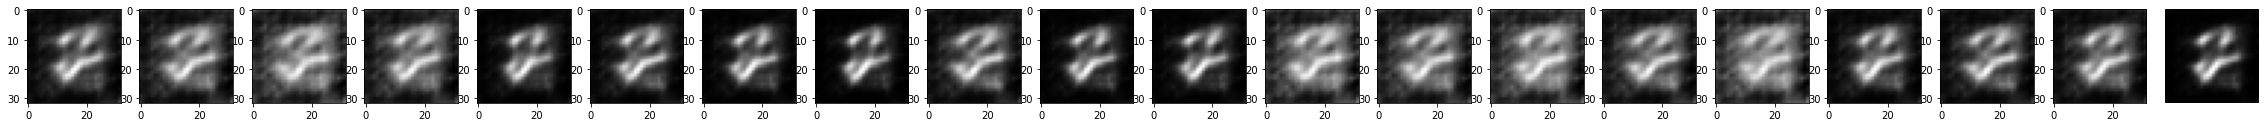

End epoch 40 of training, plotting Generator results:


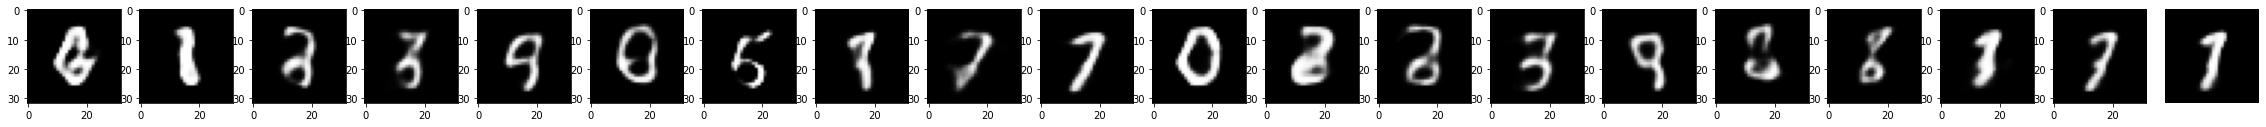

End epoch 80 of training, plotting Generator results:


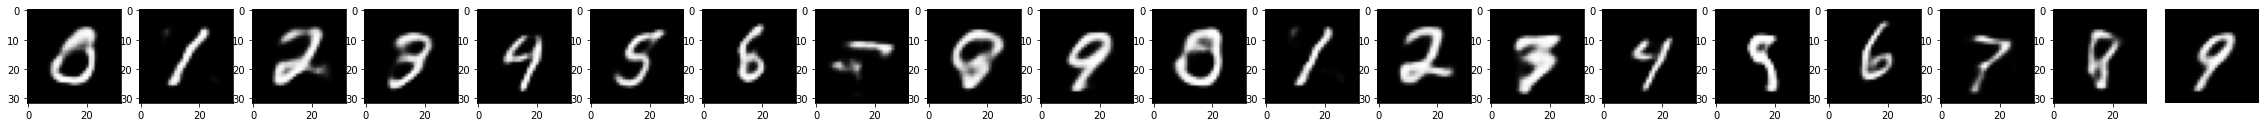

End epoch 120 of training, plotting Generator results:


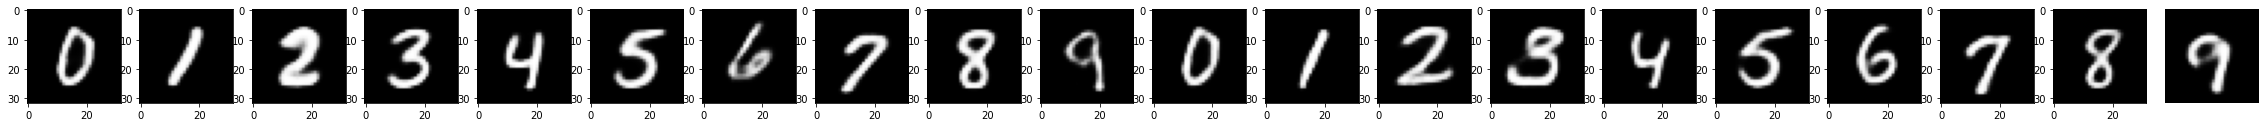

End epoch 160 of training, plotting Generator results:


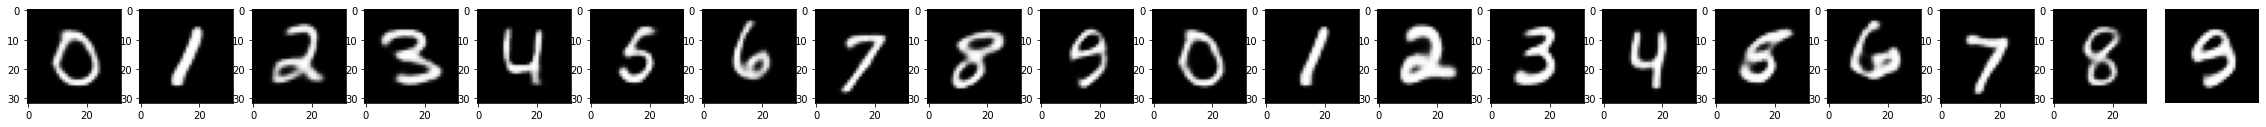

End epoch 200 of training, plotting Generator results:


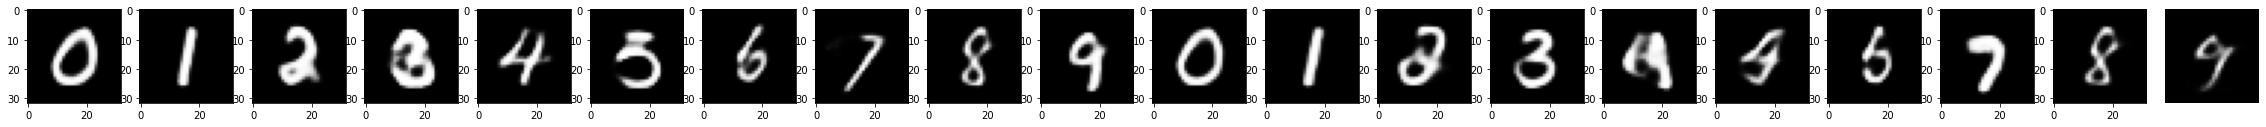

In [14]:
#@title Prepare the dataset & Train
with_user_input = True #@param {type:"boolean"}
load_gan = False  # @param {type:"boolean"}
train_gan = True  # @param {type:"boolean"}
batch_size = 128
encoder_latent_codes = np.concatenate([encoder.predict(x_train), encoder.predict(x_test)])
if with_user_input:
    labels = np.concatenate((y_train_numerical, y_test_numerical))[..., np.newaxis]
    training_vecs = np.concatenate((labels, encoder_latent_codes), axis=1)
    discriminator_ = discriminator_2
else:
    training_vecs = encoder_latent_codes
    discriminator_ = discriminator_1

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
dataset = tf.data.Dataset.from_tensor_slices(training_vecs)
dataset = dataset.shuffle(buffer_size=2048).batch(batch_size)

gan = GAN(discriminator_, generator, GAN_latent_dim=generator_input_dim,
          with_user_input=with_user_input)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=loss_fn
)


gan_checkpoint_path_1 = f"/content/drive/MyDrive/Colab Notebooks/DL5/{gan.name}_model_save/cp.ckpt"

if load_gan:
    gan.load_weights(gan_checkpoint_path_1)

epochs_num = 201 #@param {type:"slider", min:5, max:500, step:1}
plotter_on_epochs_step = 40 #@param {type:"slider", min:1, max:100, step:1}

if train_gan:
    checkpoint_dir = os.path.dirname(gan_checkpoint_path_1)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=gan_checkpoint_path_1,
                                                    save_weights_only=True)
    gan.fit(dataset.take(60000), verbose=0, epochs=epochs_num,
            callbacks=[cp_callback,
                      TqdmCallback(verbose=1),
                      PlotGenOutputsCallback(gan, plotter_on_epochs_step)])


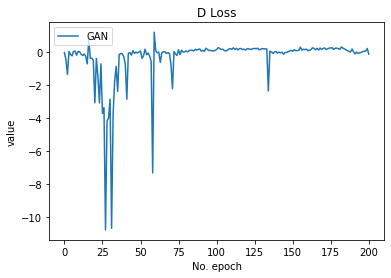

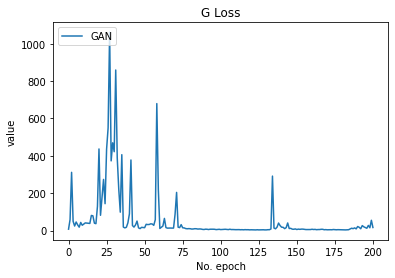

In [15]:
plot([gan], gan.history.history.keys())

In [16]:
#@title Interpolation Plotter
def plot_intorpolation(encoder_, vec_1, vec_2):
    for i in range(4, 16, 1):
        alpha = float(i) / 20.0
        plt.figure(figsize=(12,4))
        f, ax = plt.subplots(1, 3)
        f.suptitle(f'alpha = {alpha}', fontsize=16)

        gen_prediction = encoder_.predict(vec_1)
        img_1 = decoder.predict(gen_prediction)

        combined_vec = alpha * vec_1 + (1-alpha) * vec_2
        gen_prediction = encoder_.predict(combined_vec)
        img_2 = decoder.predict(gen_prediction)

        gen_prediction = encoder_.predict(vec_2)
        img_3 = decoder.predict(gen_prediction)

        ax[0].imshow(img_1.reshape(32, 32))
        ax[1].imshow(img_2.reshape(32, 32))
        ax[2].imshow(img_3.reshape(32, 32))

        plt.gray()
        plt.axis('off')
        plt.show()
    

<Figure size 864x288 with 0 Axes>

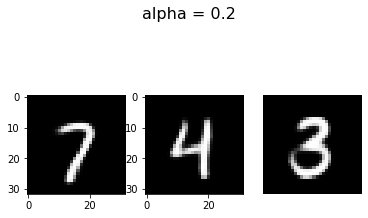

<Figure size 864x288 with 0 Axes>

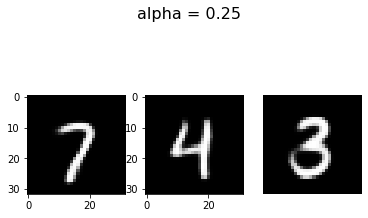

<Figure size 864x288 with 0 Axes>

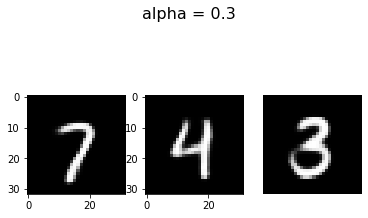

<Figure size 864x288 with 0 Axes>

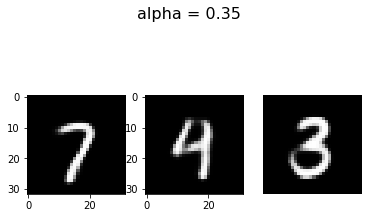

<Figure size 864x288 with 0 Axes>

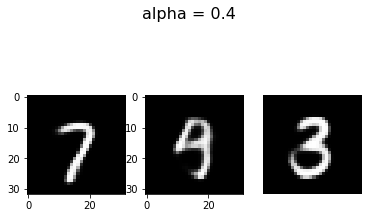

<Figure size 864x288 with 0 Axes>

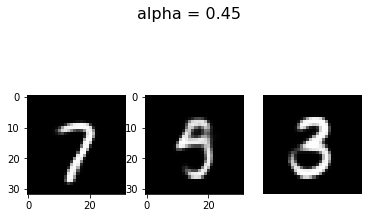

<Figure size 864x288 with 0 Axes>

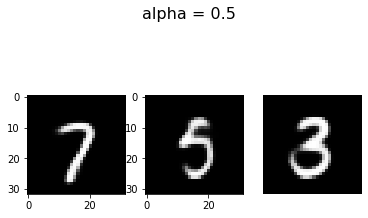

<Figure size 864x288 with 0 Axes>

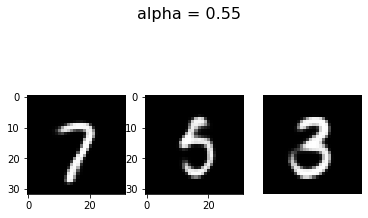

<Figure size 864x288 with 0 Axes>

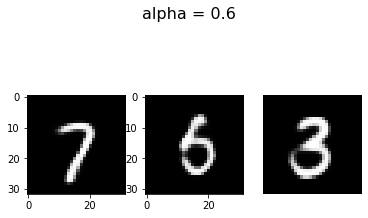

<Figure size 864x288 with 0 Axes>

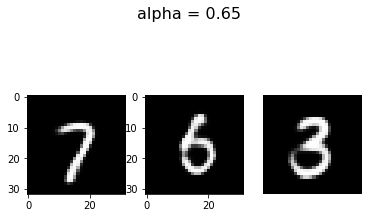

<Figure size 864x288 with 0 Axes>

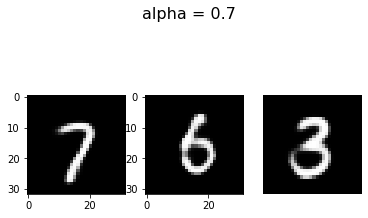

<Figure size 864x288 with 0 Axes>

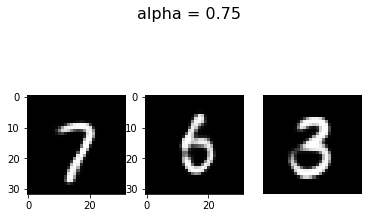

In [17]:
#@title Interpolation within GAN latent code
rand_vec_1 = tf.random.normal(shape=(1, generator_input_dim-int(gan.with_user_input)))
rand_vec_2 = tf.random.normal(shape=(1, generator_input_dim-int(gan.with_user_input)))
if gan.with_user_input:
    random_user_input = tf.dtypes.cast(tf.random.uniform((1,2), 0, 9, dtype=tf.int32), tf.float32)
    rand_vec_1 = tf.concat([random_user_input[:, :1],
                                      rand_vec_1], axis=1)
    rand_vec_2 = tf.concat([random_user_input[:, 1:],
                                      rand_vec_2], axis=1)
plot_intorpolation(generator, rand_vec_1, rand_vec_2)

<Figure size 864x288 with 0 Axes>

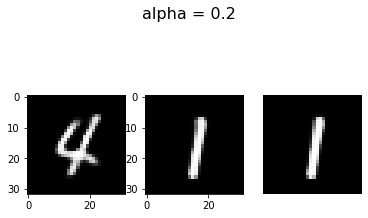

<Figure size 864x288 with 0 Axes>

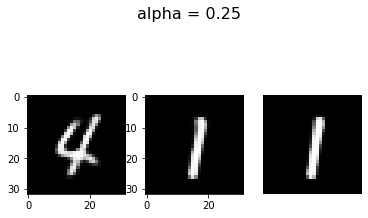

<Figure size 864x288 with 0 Axes>

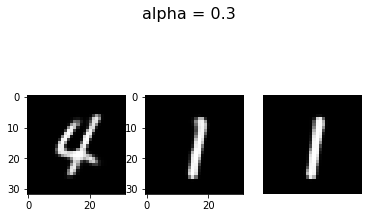

<Figure size 864x288 with 0 Axes>

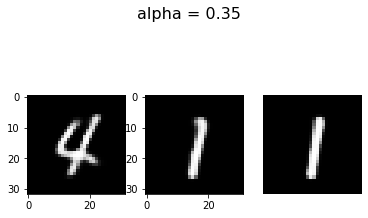

<Figure size 864x288 with 0 Axes>

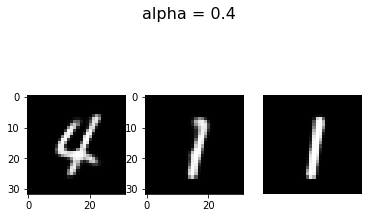

<Figure size 864x288 with 0 Axes>

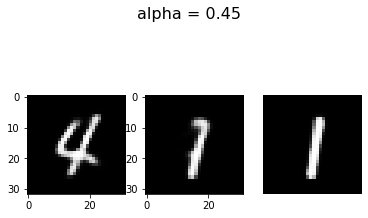

<Figure size 864x288 with 0 Axes>

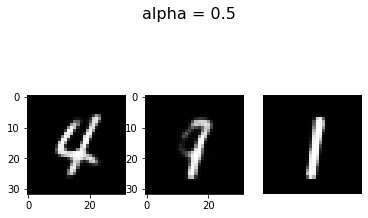

<Figure size 864x288 with 0 Axes>

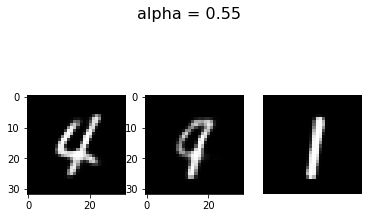

<Figure size 864x288 with 0 Axes>

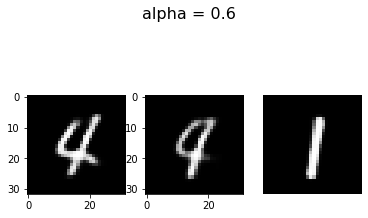

<Figure size 864x288 with 0 Axes>

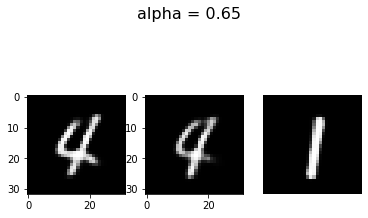

<Figure size 864x288 with 0 Axes>

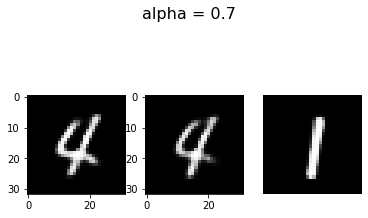

<Figure size 864x288 with 0 Axes>

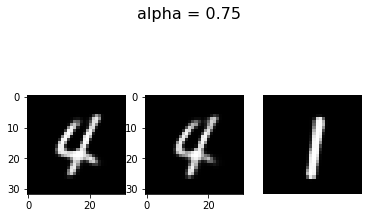

In [18]:
#@title Interpolation within AE latent code
i, j = np.random.choice(range(x_test.shape[0]), 2)
img__1, img__2 = x_test[i:i+1], x_test[j:j+1]
plot_intorpolation(encoder, img__1, img__2)


In [19]:

#@markdown We can see that the GAN latent space interpolation was more robust in the outputs as expected, the GAN sampled from one of the learned distributions rather than averaging them while the encoder of the AE interpolation gave more mixed digits espicially around the middle.
